<a href="https://colab.research.google.com/github/002XYZ/NNTI-Proj/blob/main/NNTI_Proj_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install datasets

In [ ]:
# import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from tqdm.notebook import tqdm
import random
import os

# 1.Fine-tune a Chemical Language Model on Lipophilicity


## --- Step 1: Load Dataset ---

The dataset we are going to use is the [Lipophilicity](https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_Lipophilicity) dataset, part of [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Lipophilicity, also known as hydrophobicity, is a measure of how readily a substance dissolves in nonpolar solvents (such as oil) compared to polar solvents (such as water).

In [ ]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [ ]:
# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

lipophilicity.csv:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4200 [00:00<?, ? examples/s]

# EDA

In [ ]:
dataset['train']

Dataset({
    features: ['SMILES', 'label'],
    num_rows: 4200
})

In [ ]:
max([len(a) for a in dataset['train']['SMILES']])

267

In [ ]:
# Explore the dataset
# For example, print the column names and display a few sample rows
# TODO: your code goes here
data=dataset['train'].to_pandas()
data.head()

,SMILES,label
0,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54
1,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18
2,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69
3,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37
4,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10


In [ ]:
min([len(a) for a in data.SMILES])

11

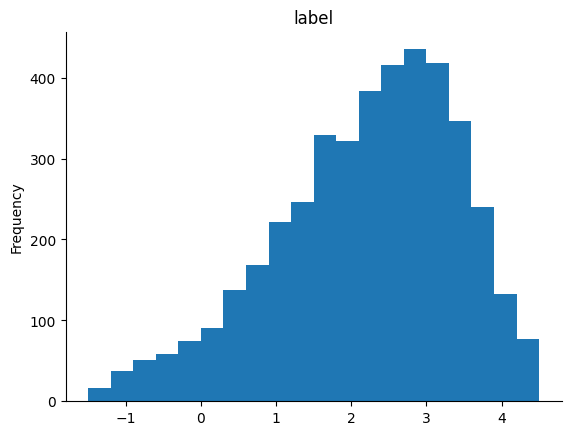

In [ ]:
# @title label

from matplotlib import pyplot as plt
data['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
data.nunique()

,0
SMILES,4200
label,553


In [ ]:
data.isnull().sum()

,0
SMILES,0
label,0


### Some EDA

In [ ]:
ert=SMILESDataset(data.SMILES,data.label,tokenizer)
qwe=[len(ert.smiles[a]) for a in range(len(ert))]
max(qwe)

NameError: name 'SMILESDataset' is not defined

In [ ]:
bin_cts=pd.cut(qwe,bins=20).value_counts().sort_index()
bin_cts=bin_cts[bin_cts>0]
df = pd.DataFrame({
    'Bin Range': bin_cts.index,
    'Frequency': bin_cts.values
})

# Add a cumulative column
df['Cumulative Frequency'] = df['Frequency'].cumsum()
df

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
hist, bin_edges = np.histogram(qwe, bins=20)

# Plot the bar plot
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
plt.title('Spread of length of SMILES')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# Necessary blocks

In [ ]:
# define a PyTorch Dataset class for handling SMILES strings and targets

# TODO: your code goes here
class SMILESDataset(Dataset):
  def __init__(self,smiles,labels,tokenizer=None) -> None:
    super().__init__()
    self.smiles=smiles
    self.labels=labels
    self.tokenizer=tokenizer

  def __len__(self):
    return len(self.smiles)

  def __getitem__(self,idx):
    sample_smiles,sample_label=self.smiles[idx],self.labels[idx]
    sample_label=torch.tensor(sample_label,dtype=torch.float32)

    if self.tokenizer:
      encoded_smiles=self.tokenizer(sample_smiles, padding=True, max_length=268, truncation=True, return_tensors="pt")
      sample_smiles = encoded_smiles['input_ids'].squeeze(0)
      attention_mask=encoded_smiles['attention_mask'].squeeze(0)

    return {'input_ids':sample_smiles,'attention_mask':attention_mask,'label':sample_label}

In [ ]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# load pre-trained model from HuggingFace
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

In [ ]:
# split the data into training and test datasets
# TODO: your code goes here
X_train,X_test,y_train,y_test=train_test_split(dataset['train']['SMILES'],dataset['train']['label'],test_size=0.2,random_state=42)

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False, # Set to False for supervised training
    mlm_probability=0.15 # Only used if mlm=True
)

In [ ]:
# construct Pytorch data loaders for both train and test datasets
# TODO: your code goes here
BATCH_SIZE = 16 # adjust based on memory constraints
# train_loader=DataLoader(SMILESDataset(X_train,y_train,tokenizer),batch_size=BATCH_SIZE,shuffle=True,collate_fn=data_collator)
train_loader=DataLoader(SMILESDataset(merged_X_train,merged_y_train,tokenizer),batch_size=BATCH_SIZE,shuffle=True,collate_fn=data_collator)
test_loader=DataLoader(SMILESDataset(X_test,y_test,tokenizer),batch_size=BATCH_SIZE,shuffle=False,collate_fn=data_collator)

# Fine tuning techniques

## LoRA class

In [ ]:
class LoRALinear(nn.Module):
    def __init__(self, base_linear, r=4, alpha=1.0, dropout=0.1):
        super().__init__()
        self.r=r
        self.alpha=alpha
        self.base_linear = base_linear
        self.dropout = nn.Dropout(dropout)

        for param in self.base_linear.parameters():
          param.requires_grad=False

        # Dimensions from the base linear layer
        in_features = base_linear.in_features
        out_features = base_linear.out_features

        # Initialize the LoRA parameters: A and B such that ΔW = A B.
        # They are initialized with small random values.
        self.lora_A = nn.Parameter(torch.randn(r, in_features) * 0.01)
        self.lora_B = nn.Parameter(torch.randn(out_features, r) * 0.01)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: compute original linear output plus LoRA adaptation.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_features).
        """
        # Original output from the frozen weight
        output = self.base_linear(x)

        # LoRA contribution: apply dropout to x, then low-rank adaptation.
        lora_out = self.lora_B @ (self.lora_A @ self.dropout(x).T)
        lora_out = lora_out.T  # shape: (batch_size, out_features)

        # Scale the LoRA output (scaling by alpha / r is common in LoRA)
        lora_out = lora_out * (self.alpha / self.r)

        return output + lora_out

## BitFit function

In [ ]:
def bitfit(model):
  for name,param in model.named_parameters():
    if 'bias' not in name:
      param.requires_grad=False

## IA3 class

In [ ]:
class IA3Adapter(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.scale=nn.Parameter(torch.ones(hidden_size))

    def forward(self, hidden_states):
        return hidden_states * self.scale

# Backbone

In [ ]:
# We need to add a regression head on the language model as we are doing a regression task.

# specify model with a regression head

class MoLFormerWithRegressionHead(nn.Module):
    # TODO: your code goes here
    def __init__(self,model,PEFT_type=None,r=4,alpha=1.0,dropout=0.1): # r and alpha are only for LoRA
        super().__init__()

        self.lang_model=model
        hidden_size=self.lang_model.config.hidden_size

        self.dropout=nn.Dropout(dropout)
        self.regression_head=nn.Linear(hidden_size,1)

        if PEFT_type=='LoRA':
          self.regression_head = LoRALinear(self.regression_head, r=r, alpha=alpha, dropout=dropout)

        elif PEFT_type=='BitFit':
          bitfit(self)

        elif PEFT_type=='IA3':
          self.adapter=IA3Adapter(hidden_size)#,adapter_size=r)


    def forward(self, input_ids, attention_mask=None,labels=None):
        outputs=self.lang_model(input_ids=input_ids,attention_mask=attention_mask)

        if hasattr(outputs,'pooler_output') and outputs.pooler_output is not None:
          pooled_output=outputs.pooler_output
        else:
          pooled_output=outputs.last_hidden_state[:,0,:]

        pooled_output=self.dropout(pooled_output)

        #In case of IA3
        if hasattr(self,'adapter'):
          pooled_output=self.adapter(pooled_output)

        regression_output=self.regression_head(pooled_output)

        loss = None
        if labels is not None:
            loss_fn = nn.MSELoss()
            loss = loss_fn(regression_output.view(-1), labels.view(-1))

        return (loss, regression_output) if loss is not None else regression_output

In [ ]:
# initialize the regression model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model=MoLFormerWithRegressionHead(model).to(device) # Base model

In [ ]:
def get_train_loader(current_epoch, total_epochs, batch_size=32,data_selection_type=None):
  if data_selection_type=='curriculum':
    return curriculum_learning_dataloader(
        # SMILESDataset(X_train,y_train,tokenizer),
        SMILESDataset(merged_X_train,merged_y_train,tokenizer),
        current_epoch,
        total_epochs,
        batch_size)
  elif data_selection_type=='active':
    return active_learning_loader
  return train_loader

In [ ]:
# TODO: your code goes here
def trainer(model, optimiser, epochs, data_selection_type=None):
  for epoch in range(1,epochs+1):
    model.train()
    total_loss,batch_count=0.0,0
    train_loader=get_train_loader(epoch, epochs, BATCH_SIZE,data_selection_type)

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
      input_ids=batch['input_ids'].to(device)
      labels=batch['label'].to(device)
      attention_mask=batch['attention_mask'].to(device)

      optimiser.zero_grad()

      loss,predictions=model(input_ids=input_ids,attention_mask=attention_mask,labels=labels)

      loss.backward()
      optimiser.step()

      total_loss+=loss.item()
      batch_count+=1

    avg_loss = total_loss / batch_count if batch_count > 0 else float('inf')
    print(f"Epoch {epoch} - Average Loss: {avg_loss:.4f}")
  return avg_loss

In [ ]:
# TODO: your code goes here

def evaluator(model, test_loader):
  # Switch the model to evaluation mode
  model.eval()

  all_predictions = []
  all_labels = []

  with torch.no_grad():
      for batch in test_loader:
          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          labels = batch['label'].to(device)

          # Get predictions (no loss is computed here as we don't pass labels)
          predictions = model(input_ids=input_ids,attention_mask=attention_mask)
          # Accessing the predicted values from the output tuple
          all_predictions.extend(predictions.cpu().detach().numpy().flatten())
          all_labels.extend(labels.cpu().numpy().flatten())

  # Calculate evaluation metrics
  mse = mean_squared_error(all_labels, all_predictions)
  r2 = r2_score(all_labels, all_predictions)

  print(f"Evaluation MSE: {mse}")
  print(f"Evaluation R² Score: {r2}")
  return {'mse':mse,'r2':r2}

## Baseline model

In [ ]:
epochs=5
optimiser=torch.optim.Adam(regression_model.parameters(),lr=1e-4)

In [ ]:
trainer(regression_model,optimiser,epochs)

Epoch 1:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1 - Average Loss: 0.9634


Epoch 2:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2 - Average Loss: 0.4841


Epoch 3:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3 - Average Loss: 0.3321


Epoch 4:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4 - Average Loss: 0.2666


Epoch 5:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5 - Average Loss: 0.2094


0.2093717730471066

In [ ]:
evaluator(regression_model,test_loader)

Evaluation MSE: 0.42209990644030615
Evaluation R² Score: 0.7143098520258467


{'mse': 0.42209990644030615, 'r2': 0.7143098520258467}

In [ ]:
# epochs_list=[5,10,15]
# lr_list=[1e-3,1e-4,1e-5]
# final_losses=[]
# final_loss_per_lr=[]
# metrics=[]
# metrics_per_lr=[]

# for epoch in epochs_list:
#   for lr in lr_list:
#     optimiser=torch.optim.Adam(regression_model.parameters(),lr=lr)
#     final_loss_per_lr.append(trainer(regression_model,optimiser,epoch))
#     metrics_per_lr.append(evaluator(regression_model,test_loader))
#   final_losses.append(final_loss_per_lr)
#   metrics.append(metrics_per_lr)
#   final_loss_per_lr=[]
#   metrics_per_lr=[]
# # trainer(regression_model,optimiser,train_loader,epochs)

In [ ]:
# final_losses=final_losses[0]
# metrics=metrics[0]

In [ ]:
# final_losses

In [ ]:
# metrics

# Data selection methods

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving External-Dataset_for_Task2.csv to External-Dataset_for_Task2.csv


In [ ]:
smalldata=pd.read_csv('/content/External-Dataset_for_Task2.csv')
smalldata.head()

,SMILES,Label
0,CCCCN1Cc2c(nc3cc(-c4ccco4)nn3c2O)C1=O,1.548
1,Cc1cc(C)c2c(n1)sc1c2ncnc1N1CCN(C)CC1,2.568
2,COC(=O)[C@H]1[C@H]2CC[C@H](C[C@@H]1OC(=O)c1ccc...,0.102
3,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Cl)c1,2.450
4,Cc1c[nH]c(/C=C2/C(=O)Nc3ccccc32)c1CCC(=O)O,1.040


In [ ]:
smalldata_X_train,smalldata_X_test,smalldata_y_train,smalldata_y_test=train_test_split(smalldata.SMILES.tolist(),smalldata.Label.tolist(),test_size=0.2,random_state=42)

In [ ]:
merged_X_train=X_train+smalldata_X_train
merged_y_train=y_train+smalldata_y_train
print(len(X_train),len(smalldata_X_train),len(merged_X_train))
len(y_train),len(smalldata_y_train),len(merged_y_train)

3360 240 3600


(3360, 240, 3600)

## Curriculum learning

In [ ]:
def difficulty(data):
  return [len(data.smiles[a]) for a in range(len(data))]

In [ ]:
def idx_selector(data, diff_scores, epoch, total_epochs, min_diff, max_diff):
  current_threshold=min_diff+(max_diff-min_diff)*(epoch/total_epochs)
  print(current_threshold)
  selected_indices = [i for i, diff in enumerate(diff_scores) if diff <= current_threshold]
  return selected_indices

In [ ]:
def curriculum_learning_dataloader(data, current_epoch, total_epochs, batch_size=32):
  difficulty_scores=difficulty(data)
  min_diff,max_diff=min(difficulty_scores),max(difficulty_scores)

  selected_idx=idx_selector(data,difficulty_scores,current_epoch,total_epochs,min_diff,max_diff)

  print(f"Curriculum Epoch {current_epoch}: Using {len(selected_idx)}/{len(data)} samples")
  return DataLoader(Subset(data, selected_idx), batch_size=batch_size, collate_fn=data_collator,shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model=MoLFormerWithRegressionHead(model).to(device) # Base model

In [ ]:
# Run this only when you want to do some more epochs and learning rates

# epochs_list=[5,10,15]
# lr_list=[1e-3,1e-4,1e-5]
# final_losses=[]
# final_loss_per_lr=[]
# metrics=[]
# metrics_per_lr=[]

# for epoch in epochs_list:
#   for lr in lr_list:
#     optimiser=torch.optim.Adam(regression_model.parameters(),lr=lr)
#     final_loss_per_lr.append(trainer(regression_model,optimiser,epoch,data_selection_type='curriculum'))
#     metrics_per_lr.append(evaluator(regression_model,test_loader))
#   final_losses.append(final_loss_per_lr)
#   print(f'for epoch {epoch} and learning rates {lr_list} final losses are {final_loss_per_lr}')
#   metrics.append(metrics_per_lr)
#   print(f'for epoch {epoch} and learning rates {lr_list} MSE and R2 are {metrics_per_lr}')
#   final_loss_per_lr=[]
#   metrics_per_lr=[]

In [ ]:
# final_losses

In [ ]:
# metrics

In [ ]:
epochs=5
batch_size=32
trainer(regression_model,optimiser,epochs,data_selection_type='curriculum')

62.2
Curriculum Epoch 1: Using 3138/3600 samples


Epoch 1:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch 1 - Average Loss: 0.2334
113.4
Curriculum Epoch 2: Using 3594/3600 samples


Epoch 2:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 - Average Loss: 0.1504
164.6
Curriculum Epoch 3: Using 3598/3600 samples


Epoch 3:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 - Average Loss: 0.1284
215.8
Curriculum Epoch 4: Using 3598/3600 samples


Epoch 4:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 - Average Loss: 0.1274
267.0
Curriculum Epoch 5: Using 3600/3600 samples


Epoch 5:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 - Average Loss: 0.1164


0.11640594614876641

In [ ]:
evaluator(regression_model,test_loader)

Evaluation MSE: 0.44260290118474
Evaluation R² Score: 0.7004327970607115


{'mse': 0.44260290118474, 'r2': 0.7004327970607115}

## Active learning via uncertainty sampling

In [ ]:
def uncertain_samples(model, vanilla_loader,num_samples,device,num_forw_pass):
    """
    Selects samples with the highest predictive uncertainty using Monte Carlo dropout.

    Args:
        model: The trained regression model.
        vanilla_loader: DataLoader for the unlabeled or full dataset.
        num_samples: The number of uncertain samples to select.
        device: torch.device (e.g., "cuda" or "cpu").
        num_forw_pass: Number of forward passes for uncertainty estimation.

    Returns:
        A list of indices corresponding to the most uncertain samples.
    """
    model.train() #So according to the active learning principal, model is used in training mode for dropout to be active
    uncertainties = []  # To store uncertainty values per sample.
    sample_indices = []  # To keep track of sample indices.

    with torch.no_grad():
        for batch_idx, batch in enumerate(vanilla_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_size = input_ids.size(0)

            predictions_list = []
            for _ in range(num_forw_pass):
                # shape (batch_size, 1)
                preds = model(input_ids=input_ids, attention_mask=attention_mask)
                predictions_list.append(preds[1])

            # shape (num_forward_passes, batch_size, 1)
            predictions_stack = torch.stack(predictions_list, dim=0)

            std_preds = predictions_stack.std(dim=0)#.squeeze(-1)  # shape: (batch_size,)

            uncertainties.extend(std_preds.cpu().tolist())

            batch_indices = list(range(batch_idx * batch_size, batch_idx * batch_size + batch_size))
            sample_indices.extend(batch_indices)

    # Sort sample indices by uncertainty in descending order.
    sorted_indices = sorted(range(len(uncertainties)), key=lambda i: uncertainties[i], reverse=True)
    selected_indices = [sample_indices[i] for i in sorted_indices[:num_samples]]

    return selected_indices

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model=MoLFormerWithRegressionHead(model).to(device) # Base model

In [ ]:
merged_train_loader=DataLoader(SMILESDataset(merged_X_train,merged_y_train,tokenizer),batch_size=BATCH_SIZE,shuffle=True,collate_fn=data_collator)

In [ ]:
selected_idx=uncertain_samples(regression_model,merged_train_loader,num_samples=512,device=device,num_forw_pass=5)
print("Selected uncertain sample indices:", selected_idx)

Selected uncertain sample indices: [220, 83, 176, 33, 110, 115, 178, 154, 6, 189, 200, 76, 100, 212, 63, 98, 194, 0, 124, 95, 24, 68, 162, 123, 7, 198, 152, 114, 25, 111, 91, 103, 211, 159, 26, 175, 85, 126, 206, 160, 201, 106, 119, 55, 195, 46, 117, 168, 40, 204, 66, 19, 218, 90, 120, 150, 188, 102, 50, 5, 15, 52, 9, 142, 172, 193, 65, 105, 101, 217, 118, 79, 132, 42, 145, 130, 164, 41, 179, 34, 141, 71, 89, 11, 2, 12, 182, 122, 96, 155, 43, 163, 44, 13, 48, 97, 135, 112, 185, 93, 156, 49, 16, 210, 158, 128, 28, 56, 54, 139, 27, 147, 221, 153, 60, 8, 222, 80, 57, 84, 181, 75, 166, 174, 62, 77, 47, 32, 104, 107, 61, 81, 196, 197, 138, 203, 134, 29, 149, 133, 36, 216, 223, 224, 10, 127, 125, 21, 199, 87, 1, 88, 187, 148, 165, 3, 94, 51, 140, 59, 192, 208, 209, 183, 39, 30, 58, 20, 109, 92, 73, 4, 219, 144, 137, 180, 37, 190, 69, 151, 167, 157, 169, 213, 22, 67, 23, 215, 86, 161, 170, 202, 38, 214, 207, 171, 82, 121, 131, 78, 72, 35, 53, 173, 70, 191, 14, 99, 18, 116, 108, 17, 136, 146, 

In [ ]:
active_learning_dataset = Subset(SMILESDataset(merged_X_train,merged_y_train,tokenizer), selected_idx)
active_learning_loader = DataLoader(active_learning_dataset, batch_size=BATCH_SIZE, shuffle=True,collate_fn=data_collator)

In [ ]:
optimiser=torch.optim.Adam(regression_model.parameters(),lr=1e-4)
epochs=5

In [ ]:
trainer(regression_model,optimiser,epochs,'active')

Epoch 1:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 - Average Loss: 1.3005


Epoch 2:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2 - Average Loss: 0.1368


Epoch 3:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3 - Average Loss: 0.1033


Epoch 4:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4 - Average Loss: 0.1270


Epoch 5:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5 - Average Loss: 0.1197


0.11973492552836736

In [ ]:
evaluator(regression_model,test_loader)

Evaluation MSE: 0.5012941405172061
Evaluation R² Score: 0.6607087682375732


{'mse': 0.5012941405172061, 'r2': 0.6607087682375732}

# Fine tuning training and evaluation

## BitFit

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model=MoLFormerWithRegressionHead(model,PEFT_type='BitFit').to(device) # BitFit

In [ ]:
optimiser = torch.optim.Adam(filter(lambda p: p.requires_grad, regression_model.parameters()), lr=1e-4) # for BitFit
epochs=5

In [ ]:
trainer(regression_model,optimiser,epochs)

Epoch 1:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 - Average Loss: 1.8400


Epoch 2:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 - Average Loss: 1.3643


Epoch 3:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 - Average Loss: 1.3277


Epoch 4:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 - Average Loss: 1.2964


Epoch 5:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 - Average Loss: 1.2434


1.2433604762289259

In [ ]:
evaluator(regression_model,test_loader)

Evaluation MSE: 1.2928678687458297
Evaluation R² Score: 0.12494741861484038


{'mse': 1.2928678687458297, 'r2': 0.12494741861484038}

In [ ]:
# Run this only when you want to do some more epochs and learning rates

# epochs_list=[5,10,15]
# lr_list=[1e-3,1e-4,1e-5]
# final_losses=[]
# final_loss_per_lr=[]
# metrics=[]
# metrics_per_lr=[]

# for epoch in epochs_list:
#   for lr in lr_list:
#     optimiser = torch.optim.AdamW(filter(lambda p: p.requires_grad, regression_model.parameters()), lr=lr) # for BitFit
#     final_loss_per_lr.append(trainer(regression_model,optimiser,epoch))
#     metrics_per_lr.append(evaluator(regression_model,test_loader))
#   final_losses.append(final_loss_per_lr)
#   print(f'for epoch {epoch} and learning rates {lr_list} final losses are {final_loss_per_lr}')
#   metrics.append(metrics_per_lr)
#   print(f'for epoch {epoch} and learning rates {lr_list} MSE and R2 are {metrics_per_lr}')
#   final_loss_per_lr=[]
#   metrics_per_lr=[]

In [ ]:
# final_losses

In [ ]:
# metrics

## LoRA

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
regression_model = MoLFormerWithRegressionHead(model,PEFT_type='LoRA',r=16,alpha=1.0).to(device) # LoRA

In [ ]:
optimiser=torch.optim.Adam(regression_model.parameters(),lr=1e-4)
epochs=5

In [ ]:
trainer(regression_model,optimiser,epochs)

Epoch 1:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1 - Average Loss: 1.8720


Epoch 2:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2 - Average Loss: 0.7838


Epoch 3:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3 - Average Loss: 0.3891


Epoch 4:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4 - Average Loss: 0.2527


Epoch 5:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5 - Average Loss: 0.2197


0.21971660682133265

In [ ]:
evaluator(regression_model,test_loader)

Evaluation MSE: 0.5028847453994874
Evaluation R² Score: 0.6596321981240671


{'mse': 0.5028847453994874, 'r2': 0.6596321981240671}

In [ ]:
# Run this only when you want to do some more epochs and learning rates

# epochs_list=[5,10,15]
# lr_list=[1e-3,1e-4,1e-5]
# rs=[4,8]
# final_losses=[]
# final_loss_per_lr=[]
# metrics=[]
# metrics_per_lr=[]
# for r in rs:
#   regression_model = MoLFormerWithRegressionHead(model,PEFT_type='LoRA',r=r,alpha=1.0).to(device) # LoRA
#   for epoch in epochs_list:
#     for lr in lr_list:
#       optimiser=torch.optim.Adam(regression_model.parameters(),lr=lr)
#       final_loss_per_lr.append(trainer(regression_model,optimiser,epoch))
#       metrics_per_lr.append(evaluator(regression_model,test_loader))
#     final_losses.append(final_loss_per_lr)
#     print(f'for r={r}, {epoch} epochs and learning rates {lr_list} final losses are {final_loss_per_lr}')
#     metrics.append(metrics_per_lr)
#     print(f'for r={r}, {epoch} epochs and learning rates {lr_list} MSE and R2 are {metrics_per_lr}')
#     final_loss_per_lr=[]
#     metrics_per_lr=[]

## IA3

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model=MoLFormerWithRegressionHead(model,PEFT_type='IA3').to(device) # IA3

In [ ]:
optimiser=torch.optim.Adam(regression_model.parameters(),lr=1e-4)
epochs=5

In [ ]:
trainer(regression_model,optimiser,epochs)

Epoch 1:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1 - Average Loss: 1.1076


Epoch 2:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2 - Average Loss: 0.2587


Epoch 3:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3 - Average Loss: 0.2090


Epoch 4:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4 - Average Loss: 0.1849


Epoch 5:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5 - Average Loss: 0.1614


0.16143543319333167

In [ ]:
evaluator(regression_model,test_loader)

Evaluation MSE: 0.4702526770774972
Evaluation R² Score: 0.6817185816682684


{'mse': 0.4702526770774972, 'r2': 0.6817185816682684}

In [ ]:
# Run this only when you want to do some more epochs and learning rates

# epochs_list=[5,10,15]
# lr_list=[1e-3,1e-4,1e-5]
# final_losses=[]
# final_loss_per_lr=[]
# metrics=[]
# metrics_per_lr=[]
# regression_model = MoLFormerWithRegressionHead(model,PEFT_type='IA3',r=r,alpha=1.0).to(device) # LoRA
# for epoch in epochs_list:
#     for lr in lr_list:
#       optimiser=torch.optim.Adam(regression_model.parameters(),lr=lr)
#       final_loss_per_lr.append(trainer(regression_model,optimiser,epoch))
#       metrics_per_lr.append(evaluator(regression_model,test_loader))
#     final_losses.append(final_loss_per_lr)
#     print(f'for r={r}, {epoch} epochs and learning rates {lr_list} final losses are {final_loss_per_lr}')
#     metrics.append(metrics_per_lr)
#     print(f'for r={r}, {epoch} epochs and learning rates {lr_list} MSE and R2 are {metrics_per_lr}')
#     final_loss_per_lr=[]
#     metrics_per_lr=[]

In [ ]:
# final_losses

In [ ]:
# metrics

# Github uploading

In [1]:
!git clone https://github.com/002XYZ/NNTI-Proj.git

Cloning into 'NNTI-Proj'...


In [3]:
!ls

NNTI-Proj  sample_data


In [4]:
%cd NNTI-Proj
!git add NNTI_Proj_Task.ipynb
!git commit -m "First commit"
!git push origin main

/content/NNTI-Proj
fatal: pathspec 'NNTI_Proj_Task.ipynb' did not match any files
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@f958f8799d68.(none)')
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/002XYZ/NNTI-Proj.git'


In [11]:
%cd /content/NNTI-Proj

/content/NNTI-Proj


In [12]:
!git add NNTI_Proj_Task3.ipynb

fatal: pathspec 'NNTI_Proj_Task3.ipynb' did not match any files
